In [1]:
from scipy.sparse import *
import numpy as np

def MyInv(Amat, Vec, FreeDofs:np.ndarray=None):
    '''
        # A is a ngsolve matrix，例如可以如下生成
        A = la.SparseMatrixd.CreateFromCOO([0,1,2], [0,1,2], [1,2,3], 3, 3)
        MyInv(A,BaseVector(np.array([1,2,3])),np.array([1,1,0],dtype=bool))
        gfu.vec.data += BaseVector(MyInv(a.mat,res:BaseVector,np.array(X.FreeDofs())))
        其中FreeDofs的dtype需要时bool才可以
    '''
    if FreeDofs is None:
        FreeDofs = np.array(np.ones(Vec.FV().NumPy().shape),dtype=bool)
    numFree = np.sum(FreeDofs)
    A_data = list(Amat.COO())
    
    A_coo = coo_matrix((A_data[2].NumPy(),(np.array(A_data[0]),np.array(A_data[1]))),Amat.shape)
    A_csr = A_coo.tocsr()
    A_new_csr = A_csr[FreeDofs][:, FreeDofs]
    b = Vec.FV().NumPy()[FreeDofs]
    
    # 使用spsolve求解Ax = b
    x = linalg.spsolve(A_new_csr, b)
    res = np.zeros(FreeDofs.shape)
    res[FreeDofs] = x
    return res

In [2]:
from ngsolve import *

In [3]:
def Pos_Transformer(Pos_GF,dim=None):
    if dim is None:
        dim = Pos_GF.dim
    else:
        assert(Pos_GF.dim == dim)
    N = int(len(Pos_GF.vec)/dim)
    coords = Pos_GF.vec.Reshape(N).NumPy().copy()
    return coords.T

Solving PDEs (vector valued) in tangential space
$$
\left(\dot{u}^{n i}, v_i\right)_{\star}+\left(\nabla u^n+\tau \sum_{i=1}^q a_{i j} \nabla \dot{u}^{n j}, \nabla v_i\right)=0
$$

方法：通过Lagrange乘子法求解无约束问题，用Lagrange乘子来设置正交性条件将本来的
$$
A u = b
$$
变成
$$
\begin{pmatrix}
A & R^T\\
R & 0
\end{pmatrix}
\begin{pmatrix}
u\\
\lambda
\end{pmatrix} = 
\begin{pmatrix}
b\\
0
\end{pmatrix}
$$

用来描述具有切向限制的有限元空间。其中 $\tilde u$ 属于标准有限元空间，例如平面上的三维有限元空间，具有所有的基函数，每个基函数的系数是一个三维的向量，表示对应vertice上的值。

而R矩阵则对应于正交性条件，可以通过mass lumping将这个限制条件作用于每个节点上，这里 $\hat u_h$ 已知，$\tilde u$需要求解，$\mu$是Lagrange乘子对应的对偶变量
$$
(\hat u_h, \tilde u \mu)_h = 0
$$

In [4]:
from netgen.meshing import Mesh, MeshPoint, Element1D, FaceDescriptor, Element0D, Element2D
from netgen.csg import Pnt
import numpy as np
from netgen.geom2d import *

In [5]:
import netgen.gui

optfile ./ng.opt does not exist - using default values
togl-version : 2
OCC module loaded
loading ngsolve library
NGSolve-6.2.2105
Using Lapack
Including sparse direct solver Pardiso
Running parallel using 8 thread(s)


### 生成一个正方形网格

In [6]:
L = 1/2
h = 0.1
periodic = SplineGeometry()
pnts = [ (-L,-L), (L,-L), (L,L), (-L,L) ]
pnums = [periodic.AppendPoint(*p) for p in pnts]

ldown = periodic.Append ( ["line", pnums[0], pnums[1]],bc="outer")
lright = periodic.Append ( ["line", pnums[1], pnums[2]], bc="outer")
periodic.Append ( ["line", pnums[3], pnums[2]], leftdomain=0, rightdomain=1, bc="outer")
periodic.Append ( ["line", pnums[0], pnums[3]], leftdomain=0, rightdomain=1, bc="outer")
ngmesh = periodic.GenerateMesh(maxh=h)

 Generate Mesh from spline geometry


In [7]:
from ngsolve import *
mymesh = Mesh(ngmesh)

### 构造有限元空间-向量值空间以及标量值空间

In [8]:
fesD = H1(mymesh, order = 1, dirichlet=mymesh.Boundaries(".*"))
## mapping的解空间，映射到3维
fesVD = fesD**3
fes = H1(mymesh, order = 1, dirichlet=mymesh.Boundaries(".*"))

### 构造多个内点处dt的复合有限元空间

* example: Gauss collocation, q = 2

$$
\begin{array}{cc|c}
\frac{1}{4} & \frac{1}{4}-\frac{\sqrt{3}}{6} & \frac{1}{2}-\frac{\sqrt{3}}{6} \\
\frac{1}{4}+\frac{\sqrt{3}}{6} & \frac{1}{4} & \frac{1}{2}+\frac{\sqrt{3}}{6} \\
\hline \frac{1}{2} & \frac{1}{2} &
\end{array}
$$
其中ci代表的是Collocation点

$$
\begin{aligned}
& \sum_{i=1}^q b_i c_i^{\nu-1}=\frac{1}{\nu}, \quad \nu=1, \ldots, q \\
& \sum_{j=1}^q a_{i j} c_j^{\nu-1}=\frac{c_i^\nu}{\nu}, \quad \nu=1, \ldots, q, i=1, \ldots, q .
\end{aligned}
$$

Solving $\dot{u}^{n i}$, i = 1,2
$$
\left(\dot{u}^{n i}, v_i\right)+\left(\tau \sum_{i=1}^q a_{i j} \nabla \dot{u}^{n j}, \nabla v_i\right)=
-\left(\nabla u^n, \nabla v_i\right)
$$

### 有限元函数
* 每个内点对应一个有限元函数-d维向量值，因此这部分有d*n\_collo个有限元函数
* 讲这些测试函数分别标记为 u1, u2, 每个是一个3d的向量
* Lagrange乘子对应一个有限元函数（没有Dirichlet边界条件）

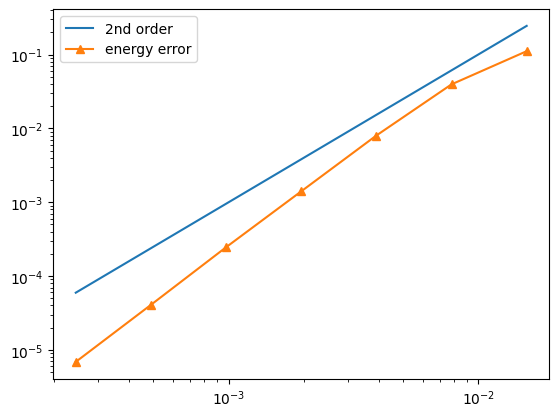

In [58]:
numer = np.array([3.1197638279687134,3.0482833111589946,3.0168390278909496,
                  3.010236100812738, 3.0090777271865665, 3.0088727132054314,
                 3.008838794466002])
exact = 3.0088318978905484
vari = np.array([0.02657563716034227,0.010258188436496394,0.0026470318769056637,
                 0.0005542593686531275,9.863510096279044e-05,1.6900847376931428e-05,
                2.883130001328924e-06])
tau = np.array([2**nn for nn in [-6,-7,-8,-9,-10,-11,-12]])
err = numer - exact
import matplotlib.pyplot as plt
plt.loglog(tau,1e3*tau**2,'-')
plt.loglog(tau,err,'-^')
plt.legend(['2nd order','energy error'])

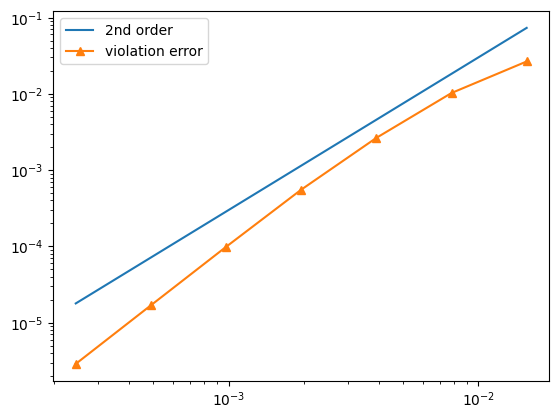

In [59]:
plt.loglog(tau,3e2*tau**2,'-')
plt.loglog(tau,vari,'-^')
plt.legend(['2nd order','violation error'])

### 有限元空间解释

* fes_ALL = fesVD* fesVD* fes * fes

中的测试函数U_N，分开写各个collocation point处的有限元函数。这样可以让 测试函数的每个分量具备向量形式
尽可能不用 power 形式来写有限元空间。

Lagrange multiplier需要是多个，因为这对应于在每个collocation 点上的正交性restriction

In [9]:
ir = IntegrationRule(points = [(0,0), (1,0), (0,1)], weights = [1/6, 1/6, 1/6])
dx_lumping = dx(intrules = { TRIG : ir })

In [10]:
n_collo = 2
d = 3
fes_ALL = fesVD*fesVD*fes*fes
U_N = fes_ALL.TrialFunction()
U0, U1, lamb0, lamb1 = U_N
V_N = fes_ALL.TestFunction()
V0, V1, mu0, mu1 = V_N

In [11]:
U_old = GridFunction(fesVD) ## Set 整点solution 既是解，也为后续外插做准备
Sol = GridFunction(fes_ALL) 
U_collo = [] ## Set Collocation 值为后续外插做准备
U_extr = [] ## Set extrapolation for constraint
for ii in range(n_collo):
    U_extr.append(GridFunction(fesVD)) 
    U_collo.append(GridFunction(fesVD))

In [12]:
A = CF((1/4,1/4-sqrt(3)/6,1/4+sqrt(3)/6,1/4),dims=(2,2)) ## 矩阵先排列完第一行再排列第二行
A_np = np.array([[1/4,1/4-sqrt(3)/6],[1/4+sqrt(3)/6,1/4]])
b = [1/2,1/2]

In [13]:
tauval = 2**(-6)
tau = Parameter(tauval)

In [14]:
Lhs = BilinearForm(fes_ALL)
Lhs += InnerProduct(U0,V0)*dx + InnerProduct(U1,V1)*dx \
    + tau*(A[0,0]*InnerProduct(grad(U0),grad(V0))
        +A[0,1]*InnerProduct(grad(U1),grad(V0))
        +A[1,0]*InnerProduct(grad(U0),grad(V1))
        +A[1,1]*InnerProduct(grad(U1),grad(V1))
          )*dx
# Lhs += InnerProduct(grad(U0),grad(V0))*dx + InnerProduct(grad(U1),grad(V1))*dx

Rhs = LinearForm(fes_ALL)
Rhs += - InnerProduct(grad(U_old),grad(V0))*dx_lumping - InnerProduct(grad(U_old),grad(V1))*dx

### Lagrangian Multiplier

* Solution 在Gauss点上和外插的u正交

**(U_extr[0], U0*lamb0)_h = 0**

$$
(\hat u, u \mu)_h = 0
$$

外插函数是GridFunction： U_extr[0]
* 外插多项式函数

$$
\begin{aligned}
& \widehat{u}^{n 1}=2(3-\sqrt{3}) u^n+(3 \sqrt{3}-5) u^{n-1,1}-\sqrt{3} u^{n-1,2} \\
& \widehat{u}^{n 2}=2(3+\sqrt{3}) u^n+\sqrt{3} u^{n-1,1}-(5+3 \sqrt{3}) u^{n-1,2}
\end{aligned}
$$

In [15]:
Lhs += InnerProduct(U_extr[0],V0)*lamb0*dx_lumping + InnerProduct(U_extr[1],V1)*lamb1*dx_lumping
Lhs += -InnerProduct(U_extr[0],U0)*mu0*dx_lumping - InnerProduct(U_extr[1],U1)*mu1*dx_lumping

### 更新解

$$
\begin{gathered}
u^{n i}:=u^n+\tau \sum_{j=1}^q a_{i j} \dot{u}^{n j}, \quad i=1, \ldots, q, \\
u^{n+1}:=u^n+\tau \sum_{i=1}^q b_i \dot{u}^{n i} .
\end{gathered}
$$

In [16]:
uval = U_old.vec.FV().NumPy()
Sollist = Sol.components
## 更新collocation插值点
for ii in range(n_collo):
    U_collo[ii].vec.data = BaseVector(uval + tauval*(A_np[ii,0]*Sollist[0].vec.FV().NumPy() 
                                                     + A_np[ii,1]*Sollist[1].vec.FV().NumPy()))
## 更新解
U_old.vec.data = BaseVector(uval + tauval*(b[0]*Sollist[0].vec.FV().NumPy() 
                                           + b[1]*Sollist[1].vec.FV().NumPy()))

### 更新外插函数

In [17]:
## 利用更新的collocation以及右端点进行外插
tmpval0 = U_collo[0].vec.FV().NumPy()
tmpval1 = U_collo[1].vec.FV().NumPy()
uval = U_old.vec.FV().NumPy()
U_extr[0].vec.data = BaseVector(2*(3- np.sqrt(3))*uval + (3*np.sqrt(3) - 5)*tmpval0 - np.sqrt(3)*tmpval1)
U_extr[1].vec.data = BaseVector(2*(3+ np.sqrt(3))*uval + np.sqrt(3)*tmpval0 - (5+3*np.sqrt(3))*tmpval1)

### Stop condition

$$
\|\dot u^n\|_{L^2}< \epsilon
$$
即solution中的L2范数小于 $\epsilon$

精确解：on $\Omega = [-1/2,1/2]^2$ with
$$
\pi_{\mathrm{st}}^{-1}(x)=\left(|x|^2+1\right)^{-1}\left[\begin{array}{c}
2 x \\
1-|x|^2
\end{array}\right] .
$$

Dirichlet边界条件通过精确解给出。初值可以通过一个在边界上为0的扰动给出。

### 测量
* 测量Dirichlet能量

$$
I = \frac12 \int_ \Omega |\nabla u|^2
$$
以及constraint violation和energy error. 精确的Dirichlet energy应该是3.009.
$$
\begin{aligned}
& \delta_{\text {uni }}\left[u_h\right]=\left\|\mathcal{I}_h\left(\left|u_h\right|^2-1\right)\right\|_{L^1} \\
& \delta_{\mathrm{ener}}\left[u_h\right]=\left|I_{\mathrm{hm}}\left[u_h\right]-I_{\mathrm{hm}}[u]\right|,
\end{aligned}
$$


### Dirichlet能量的计算

In [18]:
xnorm = Norm(CF((x,y)))
factor = (xnorm**2 + 1)**(-1)
uexact = CF((factor*2*x,factor*2*y,factor*(1-xnorm**2)))
perturb = uexact + CF(( sin(2*pi*x)*sin(2*pi*y), 0, 0 ))

In [19]:
U_old.Interpolate(uexact)
Energy = 1/2*Integrate(InnerProduct(grad(U_old),grad(U_old)), mymesh, element_wise=False)
print('Energy of exact mapping is {}'.format(Energy))

Energy of exact mapping is 2.99607492600693


In [20]:
U_old.Interpolate(perturb)
Energy = 1/2*Integrate(InnerProduct(grad(U_old),grad(U_old)), mymesh, element_wise=False)
print('Energy of perturbed initial mapping is {}'.format(Energy))

Energy of perturbed initial mapping is 12.387060463257106


### 扰动的初值需要压缩以满足模长为1
* 查看U_old的形式, U_old是向量函数

In [21]:
Draw(U_old,mymesh,'f')

In [22]:
res = Pos_Transformer(U_old)
res2 = res/np.linalg.norm(res,axis =1)[:,None]
U_old.vec.data = BaseVector(res2.flatten('F'))

## 梯度下降

In [23]:
GetEnergy = lambda expr: 1/2*Integrate(InnerProduct(grad(expr),grad(expr)), mymesh, element_wise=False)
GetH1 = lambda expr: np.sqrt(Integrate( InnerProduct(grad(expr),grad(expr))+InnerProduct(expr,expr), mymesh, element_wise=False))
GetL2 = lambda expr: np.sqrt(Integrate( InnerProduct(expr,expr), mymesh, element_wise=False))

### 设定初值时间步中的Collocation点的近似


$$
\begin{gathered}
u^{n i}:=u^n+\tau \sum_{j=1}^q a_{i j} \dot{u}^{n j}, \quad i=1, \ldots, q,
\end{gathered}
$$

Euler method: Solving $\dot{u}^{n i}$, i = 1
$$
\left(\dot{u}^{n i}, v_i\right)+\left(\tau \nabla \dot{u}^{n j}, \nabla v_i\right)=
-\left(\nabla u^n, \nabla v_i\right)
$$
Under constraint 和 $u^0$ 正交

In [ ]:
c0 = (3-np.sqrt(3))/6
c1 = (3+np.sqrt(3))/6
tau_mid = Parameter(c0*tauval)
fes_Euler = fesVD*fes
U_Euler = fes_Euler.TrialFunction()
UEuler0, lambEuler0 = U_Euler
V_Euler = fes_Euler.TestFunction()
VEuler0, muEuler0 = V_Euler
Sol_E = GridFunction(fes_Euler)

Lhs_E = BilinearForm(fes_Euler)
Lhs_E += InnerProduct(UEuler0,VEuler0)*dx + tau_mid*(InnerProduct(grad(UEuler0),grad(VEuler0)))*dx

Rhs_E = LinearForm(fes_Euler)
Rhs_E += - InnerProduct(grad(U_old),grad(VEuler0))*dx
Lhs_E += InnerProduct(U_old,VEuler0)*lambEuler0*dx_lumping
Lhs_E += -InnerProduct(U_old,UEuler0)*muEuler0*dx_lumping
Lhs_E.Assemble()
Rhs_E.Assemble()

Sol_E.vec.data = BaseVector(MyInv(Lhs_E.mat, Rhs_E.vec,FreeDofs=np.array(fes_Euler.FreeDofs())))
U_extr[0].vec.data = BaseVector(U_old.vec.FV().NumPy() + c0*tauval*Sol_E.components[0].vec.FV().NumPy())

tau_mid.Set(c1*tauval)
Lhs_E.Assemble()
Sol_E.vec.data = BaseVector(MyInv(Lhs_E.mat, Rhs_E.vec,FreeDofs=np.array(fes_Euler.FreeDofs())))
U_extr[1].vec.data = BaseVector(U_old.vec.FV().NumPy() + c1*tauval*Sol_E.components[0].vec.FV().NumPy())

In [32]:
Variation = GridFunction(fes)
Variation.Interpolate(InnerProduct(U_old,U_old)-1)
delta_viration = Integrate(Variation,mymesh,element_wise=False)
print(delta_viration)

5.2430265491429605e-18


In [33]:
Eng_set = []
eps_set = []
eps = np.inf
eps0 = 1e-5
N_iter = 0
while eps>eps0 and N_iter < 500:
    ## 每个时间步更新U_old，U_extr（用来计算新的时间区间上的collocation点值，满足正交性条件），再用外插分别更新这两项
    Lhs.Assemble()
    Rhs.Assemble()
    
    Sol.vec.data = BaseVector(MyInv(Lhs.mat, Rhs.vec,FreeDofs=np.array(fes_ALL.FreeDofs())))
    
    ## 储存n-1时刻的mapping
    uval = U_old.vec.FV().NumPy()
    ## 计算collocation点上的时间导数
    Sollist = Sol.components
    ## 更新collocation插值点
    for ii in range(n_collo):
        U_collo[ii].vec.data = BaseVector(uval + tauval*(A_np[ii,0]*Sollist[0].vec.FV().NumPy() 
                                                         + A_np[ii,1]*Sollist[1].vec.FV().NumPy()))
    ## 更新解
    U_old.vec.data = BaseVector(uval + tauval*(b[0]*Sollist[0].vec.FV().NumPy() 
                                               + b[1]*Sollist[1].vec.FV().NumPy()))
    
    ## 利用更新的collocation以及右端点进行外插
    tmpval0 = U_collo[0].vec.FV().NumPy()
    tmpval1 = U_collo[1].vec.FV().NumPy()
    uval = U_old.vec.FV().NumPy()
    U_extr[0].vec.data = BaseVector(2*(3- np.sqrt(3))*uval + (3*np.sqrt(3) - 5)*tmpval0 - np.sqrt(3)*tmpval1)
    U_extr[1].vec.data = BaseVector(2*(3+ np.sqrt(3))*uval + np.sqrt(3)*tmpval0 - (5+3*np.sqrt(3))*tmpval1)

    eps = GetL2(Sollist[0])+GetL2(Sollist[1])
    N_iter = N_iter + 1
    Eng_set.append(GetEnergy(U_old))
    eps_set.append(eps)

115
3.0900789293866344


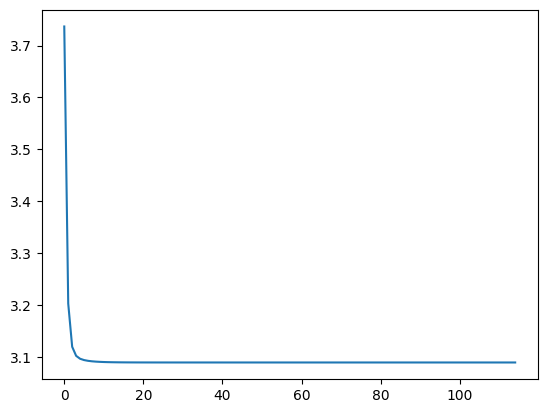

In [34]:
import matplotlib.pyplot as plt
plt.plot(Eng_set)

print(N_iter)
print(Eng_set[-1])

0.0007970698400853549


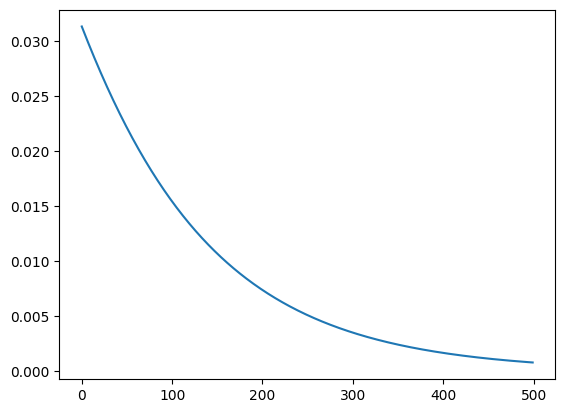

In [88]:
plt.plot(eps_set)
print(eps_set[-1])

In [108]:
Draw(perturb,mymesh,'pert')

In [111]:
Variation.Interpolate(InnerProduct(U_old,U_old)-1)
delta_viration = Integrate(sqrt(Variation**2),mymesh,element_wise=False)
print(delta_viration)
Draw(Variation,mymesh,'vari')

0.2446402970149769


In [109]:
Draw(Norm(U_old-uexact),mymesh,'test')